# Implementando uma LSTM com Grid Search para escolher melhor os parâmetros no Mapa Logístico

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para LSTM

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [5]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [6]:
from pibic2020.models import lstm_model as lstm

### 1.3 Bibliotecas dos sistemas caóticos

In [7]:
from pibic2020.tools import timeseries as times
from pibic2020.data import logistic as logmap

## 2. Gerando a série temporal do mapa logístico

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original. Utilizaremos  $r = 3.86$, o que faz com que o sistema esteja em caos.

In [8]:
x_inicial = 0.5
n_inicial = 0
n_iteracoes = 5000
r=3.86
estados = np.array([x_inicial, n_inicial])

In [9]:
mapa = logmap.MapaLogistico(estado_inicial=estados, r=r)

In [10]:
estados = mapa.simular(n_iteracoes)

In [11]:
x = estados[:, 0]
n = estados[:, 1]

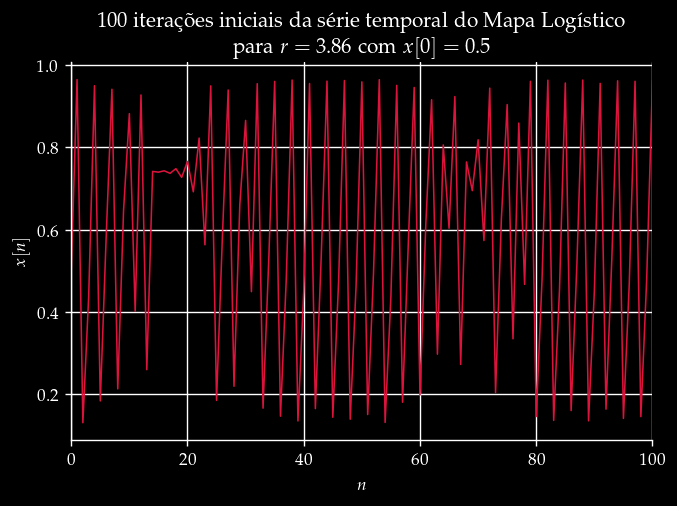

In [12]:
fig, ax = plt.subplots()
ax.plot(n, x, color='Crimson', linewidth=0.9)

ax.set_title("$100$ iterações iniciais da série temporal do Mapa Logístico\n para $r =$ " + str(r) + " com $x[0] =$ " + str(x[0]))
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(0,100)
    
ax.grid(True)
sns.despine()

plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [12]:
K = 4
L = 3
tam_teste = 0.15

In [13]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [15]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

### 2.2 Pré-processamento nos dados de entrada

In [16]:
len_treino = X_treino.shape[0]
len_teste = X_teste.shape[0]
n_samples = X_treino.shape[1]

In [17]:
X_treino = np.reshape(X_treino,(len_treino, n_samples, 1))
X_teste = np.reshape(X_teste,(len_teste, n_samples, 1))

## 3. Definindo o modelo para a LSTM e executando os Gridsearches

In [18]:
holdout = TimeSeriesSplit(n_splits=4, test_size=int(0.1*len(y_treino)), gap=0)

### 3.1 Criando o objeto da LSTM

In [19]:
lstm = lstm.ModeloLSTM(input_shape = (K, 1))

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [20]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  init_mode = ['glorot_normal', 'glorot_uniform'],
                  n_units = [5, 10, 15, 20, 30, 50, 75, 100],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [21]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size*.

In [23]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32])

In [24]:
model_cv_1 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0)

In [25]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [26]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END .......................................batch_size=2; total time= 3.1min
[CV] END .......................................batch_size=2; total time= 3.7min
[CV] END .......................................batch_size=2; total time= 4.0min
[CV] END .......................................batch_size=2; total time= 4.6min
[CV] END .......................................batch_size=4; total time= 1.6min
[CV] END .......................................batch_size=4; total time= 1.8min
[CV] END .......................................batch_size=4; total time= 2.1min
[CV] END .......................................batch_size=4; total time= 2.4min
[CV] END .......................................batch_size=8; total time=  50.6s
[CV] END .......................................batch_size=8; total time=  58.6s
[CV] END .......................................batch_size=8; total time= 1.1min
[CV] END .......................................b

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.001495 using {'batch_size': 2}


In [28]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.001495 (0.000851) with: {'batch_size': 2}
-0.003774 (0.002275) with: {'batch_size': 4}
-0.017849 (0.012366) with: {'batch_size': 8}
-0.033743 (0.006475) with: {'batch_size': 16}
-0.041547 (0.007093) with: {'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [29]:
model_cv_2 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2)

In [30]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [33]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [34]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END ................................learning_rate=0.001; total time= 3.3min
[CV] END ................................learning_rate=0.001; total time= 3.7min
[CV] END ................................learning_rate=0.001; total time= 4.1min
[CV] END ................................learning_rate=0.001; total time= 4.5min
[CV] END ................................learning_rate=0.003; total time= 3.1min
[CV] END ................................learning_rate=0.003; total time= 3.5min
[CV] END ................................learning_rate=0.003; total time= 4.1min
[CV] END ................................learning_rate=0.003; total time= 4.6min
[CV] END ................................learning_rate=0.005; total time= 3.0min
[CV] END ................................learning_rate=0.005; total time= 3.5min
[CV] END ................................learning_rate=0.005; total time= 3.9min
[CV] END ................................learning

In [35]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000312 using {'learning_rate': 0.008}


In [36]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.001037 (0.000652) with: {'learning_rate': 0.001}
-0.000434 (0.000120) with: {'learning_rate': 0.003}
-0.001386 (0.000885) with: {'learning_rate': 0.005}
-0.000312 (0.000115) with: {'learning_rate': 0.008}
-0.000722 (0.000071) with: {'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária, considerando a $\tanh$ como função de ativação.

In [22]:
model_cv_3 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.008)

In [23]:
param_grid_3 = dict(init_mode = ['glorot_uniform', 'glorot_normal'])

In [24]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [25]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ...........................init_mode=glorot_uniform; total time= 3.7min
[CV] END ...........................init_mode=glorot_uniform; total time= 3.4min
[CV] END ...........................init_mode=glorot_uniform; total time= 4.4min
[CV] END ...........................init_mode=glorot_uniform; total time= 5.3min
[CV] END ............................init_mode=glorot_normal; total time= 3.1min
[CV] END ............................init_mode=glorot_normal; total time= 3.5min
[CV] END ............................init_mode=glorot_normal; total time= 4.0min
[CV] END ............................init_mode=glorot_normal; total time= 4.7min


In [26]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000563 using {'init_mode': 'glorot_uniform'}


In [27]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000563 (0.000305) with: {'init_mode': 'glorot_uniform'}
-0.000922 (0.000436) with: {'init_mode': 'glorot_normal'}


### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o número de unidades *LSTM* na camada intermediária.

In [22]:
model_cv_4 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.008, init_mode='glorot_uniform')

In [23]:
param_grid_4 = dict(n_units = [5, 10, 15, 20, 30, 50, 75, 100])

In [24]:
grid = GridSearchCV(estimator=model_cv_4, param_grid=param_grid_4, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [25]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ..........................................n_units=5; total time= 3.2min
[CV] END ..........................................n_units=5; total time= 3.9min
[CV] END ..........................................n_units=5; total time= 4.5min
[CV] END ..........................................n_units=5; total time= 5.0min
[CV] END .........................................n_units=10; total time= 3.4min
[CV] END .........................................n_units=10; total time= 3.7min
[CV] END .........................................n_units=10; total time= 4.3min
[CV] END .........................................n_units=10; total time= 4.8min
[CV] END .........................................n_units=15; total time= 3.3min
[CV] END .........................................n_units=15; total time= 3.8min
[CV] END .........................................n_units=15; total time= 4.3min
[CV] END ........................................

In [26]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000314 using {'n_units': 100}


In [27]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.002214 (0.002815) with: {'n_units': 5}
-0.000774 (0.000546) with: {'n_units': 10}
-0.000457 (0.000077) with: {'n_units': 15}
-0.001475 (0.001349) with: {'n_units': 20}
-0.001797 (0.001213) with: {'n_units': 30}
-0.000972 (0.001052) with: {'n_units': 50}
-0.000428 (0.000152) with: {'n_units': 75}
-0.000314 (0.000138) with: {'n_units': 100}


### Treino com o melhor modelo

#### Dados de entrada

In [ ]:
X_treino, X_teste, X_val, y_treino, y_teste, y_val = serie_temporal.dividir_treino_teste_validacao(tam_teste=0.15, tam_val=0.1)

#### Ajuste no modelo

In [19]:
model = lstm.ModeloLSTM(input_shape = (K, 1), name='LSTM-logistic')

In [20]:
model.criar_modelo(n_units=100, init_mode='glorot_uniform')

In [21]:
model.montar(learning_rate=0.008)

In [22]:
model.visualizar()

Model: "LSTM-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_lstm (LSTM)           (None, 100)               40800     
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.treinar(X_treino, X_val, y_treino, y_val, batch_size=2)

Epoch 1/100
1910/1910 [==============================] - 6s 2ms/step - loss: 0.0664 - val_loss: 0.0432
Epoch 2/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0456 - val_loss: 0.0411
Epoch 3/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0401 - val_loss: 0.0361
Epoch 4/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0357 - val_loss: 0.0323
Epoch 5/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0326 - val_loss: 0.0304
Epoch 6/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0278 - val_loss: 0.0246
Epoch 7/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0183 - val_loss: 0.0199
Epoch 8/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 9/100
1910/1910 [==============================] - 3s 2ms/step - loss: 0.0106 - val_loss: 0.0142
Epoch 10/100
1910/1910 [==============================] - 3s 2ms/step - l

## Teste com o melhor modelo

In [25]:
y_pred = model.predicao(X_teste)

### Gráfico

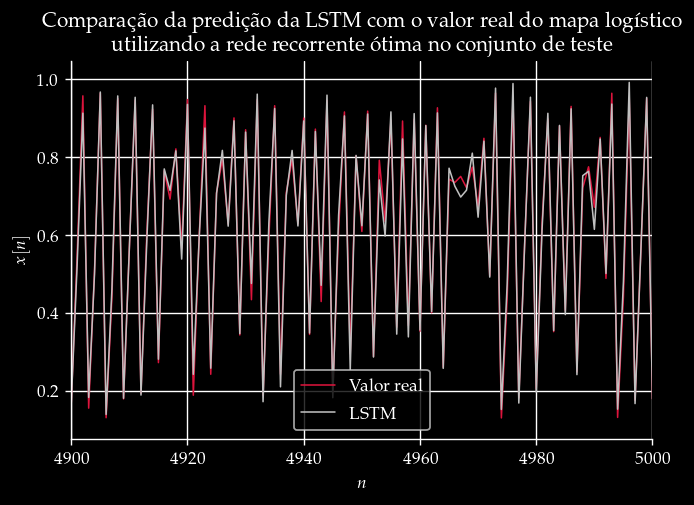

In [39]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='Crimson', label='Valor real', linewidth=0.9)
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Silver', label='LSTM', linewidth=0.9)

ax.set_title("Comparação da predição da LSTM com o valor real do mapa logístico\n utilizando a rede recorrente ótima no conjunto de teste")
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(4900, 5000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../images/lstm/performance/lstm-vs-logistic.png")

### Erro Quadrático Médio

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.0003627962491332843


### Salvando o Modelo

In [35]:
model.salvar("../../../models/lstm/lstm-logistic", h5="ON")

O modelo foi salvo!
